# Predicting house prices with advanced regression models

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

In [22]:
%matplotlib inline

In [23]:
sns.set() ## set Seaborn defaults

In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [25]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [26]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Exploratory data analysis

- First, let us take a close look at the correlations between the predictor variables and the target variable.

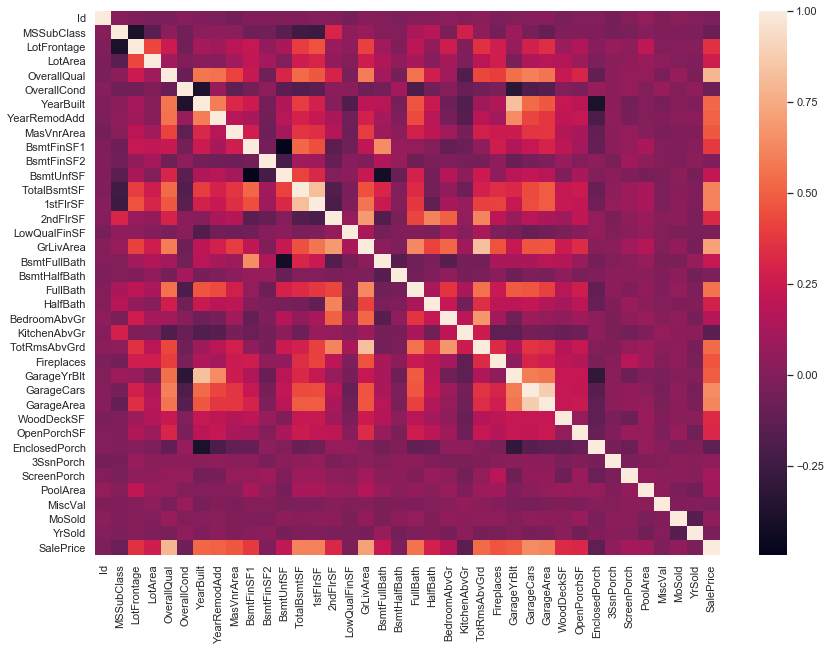

In [27]:
# Correlation matrix
plt.figure(figsize=(14,10))
sns.heatmap(train.corr())  ## only for numerical features

What is interesting in the above plot is the last row, i.e. `SalePrice`. We notice quite a few red squares there which signifies high correlation. These features will have the the highest predictive power in our ML models. We will now take a detailed look at these features. 

Note: One can see two 2x2 white squares along the diagonal. It implies that the pairs `TotalBsmtSF` & `1stFlrSF`, and `GarageCars` & `GarageArea` are highly correlated, which is a sign of **collinearity**. 

In [28]:
train.corr()['SalePrice'].sort_values(ascending=False)[1:]

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

#### What we will do now is to do an exploratory analysis of those features which show the *strongest correlation* with our target variable `SalePrice`.

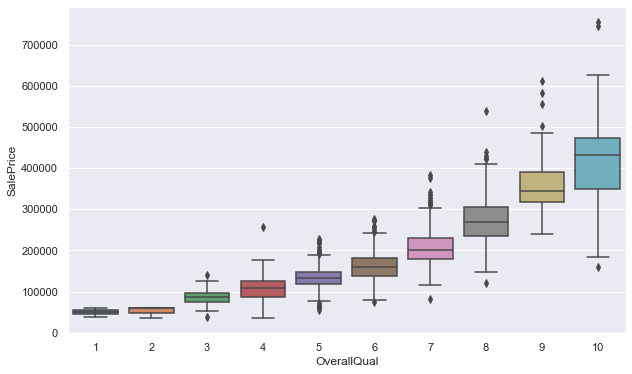

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(x=train['OverallQual'],y = train['SalePrice'])


Such a nice relationship! Up to `OVerallQual` = 6 it hs a relatively gentle slope, but in the regime `OVerallQual` > 6, `SalePrice` really takes off and shows a steeper trend. One can tell that this will be one of the strong predictor variables while analyzing feature importances. I believe that this feature is a combination of other predictor variables in the dataset and therefore we get such a smooth and clean relationship.

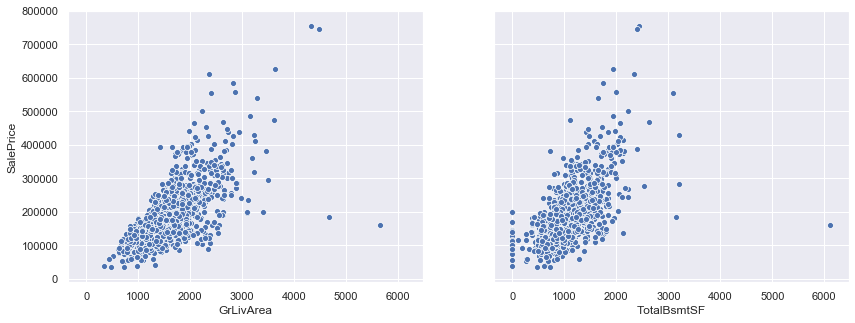

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey= True,sharex=True)
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'],ax=axs[0])
sns.scatterplot(train['TotalBsmtSF'],train['SalePrice'], ax=axs[1])

As expected, both `TotalBsmtSF` and `GrLivArea` show strong linear correlation with `SalePrice`. Furthermore, `SalePrice` shows a steeper relationship with `TotalBsmtSF` (both plots are drawn on the same scale).

Text(0.5, 1.0, 'Histogram of GrLivArea and TotalBsmtSF')

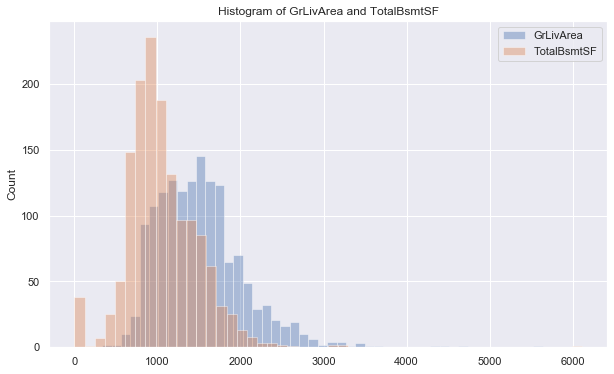

In [31]:
plt.figure(figsize=(10,6))
sns.distplot(train['GrLivArea'], label = 'GrLivArea',kde=False)
sns.distplot(train['TotalBsmtSF'], label = 'TotalBsmtSF',kde=False)
plt.legend()
plt.xlabel('')
plt.ylabel('Count')
plt.title('Histogram of GrLivArea and TotalBsmtSF')

Both **GrLivArea** and **TotalBsmtSF** show positive skewness. We will do the normality tests later in the notebook.

### Removing outliers

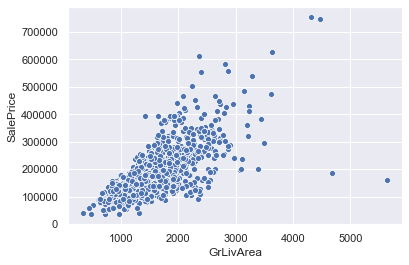

In [32]:
sns.scatterplot(train['GrLivArea'], train['SalePrice'])

- As evident from the living area vs. SalePrice plot, there are 2 clear outliers that one would wish to remove as part of the data cleaning process before proceeding to the modelling section. The [paper](http://jse.amstat.org/v19n3/decock.pdf) which introduced this dataset recommends removing all the 4 data points in the training set which has more than 4000 sqft of living area. But I chose to remove only those two points which correspond to huge houses priced rather inappropriately.

In [33]:
outliers_index = train.loc[train['GrLivArea']>4500, :].index
train = train.drop(outliers_index)
target = train['SalePrice']  ## target variable that we need to predict

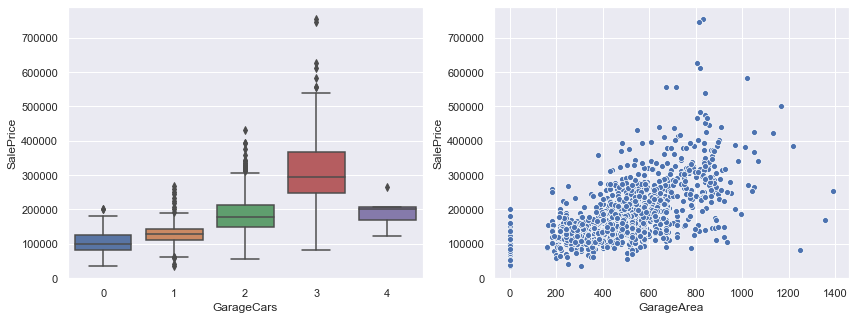

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x=train['GarageCars'], y=target,ax=axs[0])
sns.scatterplot(x=train['GarageArea'],y=target,ax=axs[1])

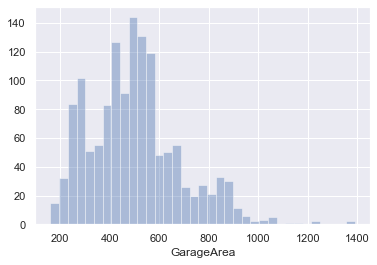

In [35]:
sns.distplot(train.loc[train['GarageArea']>0, 'GarageArea'],kde=False)

In [36]:
train['GarageCars'].value_counts()
#train.groupby('GarageCars').size()

2    823
1    369
3    180
0     81
4      5
Name: GarageCars, dtype: int64

In [37]:
train['YearBuilt'].describe()

count    1458.000000
mean     1971.218107
std        30.193754
min      1872.000000
25%      1954.000000
50%      1972.500000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

Text(0, 0.5, 'Count')

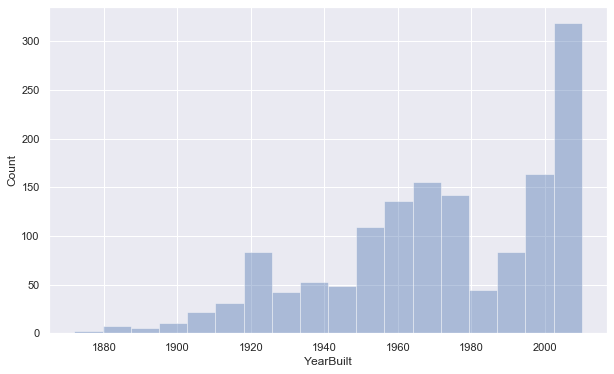

In [38]:
plt.figure(figsize=(10,6))
sns.distplot(train['YearBuilt'],kde=False)
plt.ylabel('Count')

50% of the houses sold were constructed after 1973, i.e. within the last 4 decades of the dataset. It is probably not a surprise considering the fact that the dataset contains sales data from 2006 to 2010 only. You are much less likely to buy a hundred-year old house.

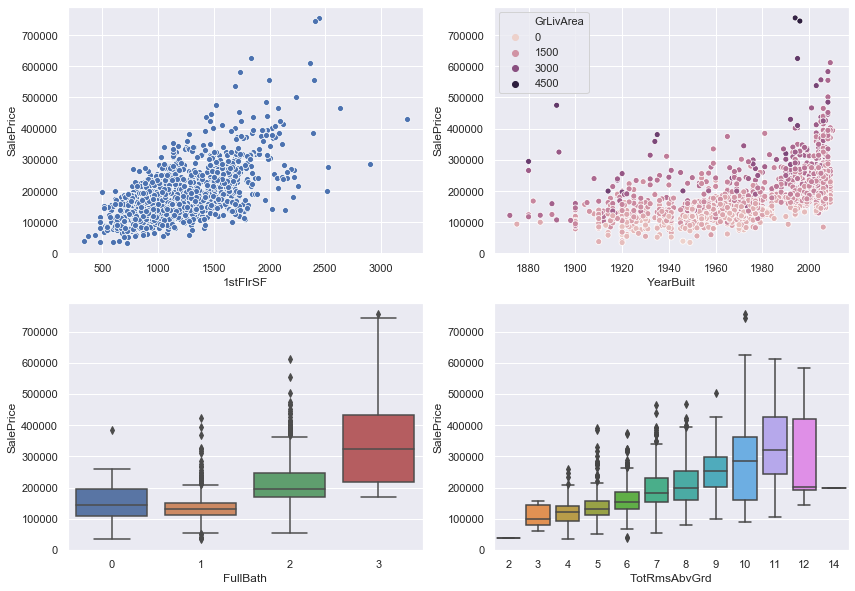

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(x=train['1stFlrSF'], y=train['SalePrice'],ax=axs[0][0])
sns.scatterplot(x=train['YearBuilt'], y=train['SalePrice'],hue=train['GrLivArea'] ,ax=axs[0][1])
sns.boxplot(train['FullBath'],train['SalePrice'], ax=axs[1][0])
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'],ax=axs[1][1])

We can see a strong correlation between `1stFlrSF` and `SalePrice`. The correlation of SalePrice with YearBuilt has to be taken with a pich of salt since the sales data is only collected between 2006-2010. That's exactly why older houses fetch lower prices with the exception of very big houses (living area is colour-coded in the figure).

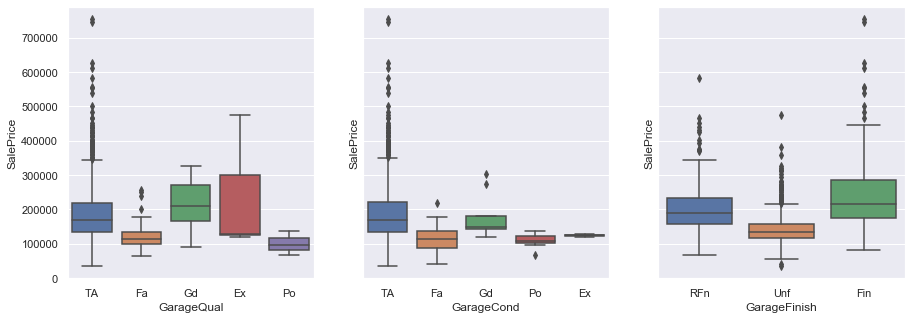

In [40]:
garage_cat_cols = ['GarageQual', 'GarageCond','GarageFinish']
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i in range(len(garage_cat_cols)):
    sns.boxplot(x=train[garage_cat_cols[i]],y=target,ax=axs[i])


While looking at the boxplots, it is worthwhile to keep in mind the number of data points available in each category. Please have a look at the category-wise value counts in the table below.

Label explanation from the documentation:

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

In [41]:
pd.concat([train['GarageQual'].value_counts(),train['GarageCond'].value_counts()],axis=1,sort=True)

,GarageQual,GarageCond
Ex,3,2
Fa,48,35
Gd,14,9
Po,3,7
TA,1309,1324


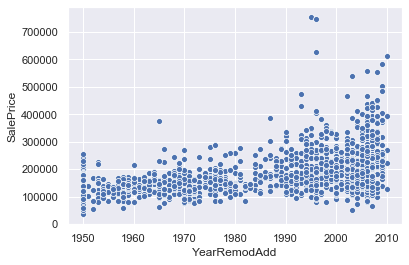

In [42]:
sns.scatterplot(train['YearRemodAdd'],train['SalePrice'])
# YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

Houses remodelled before 1990 does not seem to attract a high price. One is much better off buying a relatively recently remodelled house. 

Out of curiosity, I decided to check the OverallQual of all the remodelled houses. It's reassuring that recent houses are better rated overall (on average).

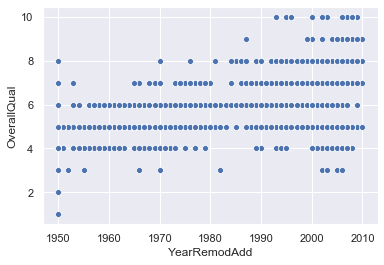

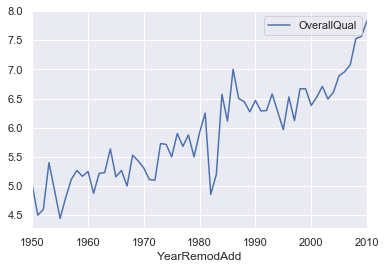

In [43]:
sns.scatterplot(train['YearRemodAdd'], train['OverallQual'])
train[['YearRemodAdd', 'OverallQual']].groupby('YearRemodAdd').mean().plot()
#train[['YearBuilt', 'OverallQual']].groupby('YearBuilt').mean().plot()

#### How does Neigbourhood influence SalePrice?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

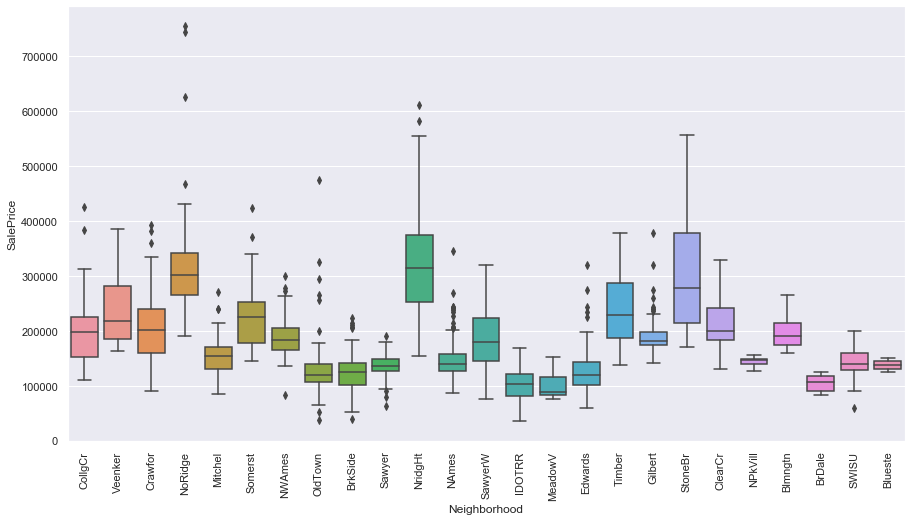

In [44]:
plt.figure(figsize=(15,8))
sns.boxplot(train['Neighborhood'], target)
plt.xticks(rotation='90')

It appears that **NoRidge** (Northridge), **NridgHt** (Northridge Heights) and **StoneBr** (Stone Brook) are the areas where the rich people of Ames prefer to stay.

### Missing values

In [45]:
train = train.drop(['SalePrice','Id'], axis=1)
test_id = test['Id']
test = test.drop('Id', axis=1)
full_data = pd.concat([train,test],axis=0,ignore_index=True)

In [46]:
def missing_data_df(df):
    '''Returns a pandas series showing which features of the input dataframe have missing values'''
    missing_df = df.isnull().sum(axis=0)
    missing_df =  missing_df[missing_df!=0]
    return missing_df

In [47]:
missing_train_test = pd.concat([train.isnull().sum(), test.isnull().sum(),full_data.isnull().sum()], axis=1, keys=['Train', 'Test', 'Full'], sort=True)
missing_train_test[missing_train_test.sum(axis=1) > 0]

,Train,Test,Full
Alley,1367,1352,2719
BsmtCond,37,45,82
BsmtExposure,38,44,82
BsmtFinSF1,0,1,1
BsmtFinSF2,0,1,1
BsmtFinType1,37,42,79
BsmtFinType2,38,42,80
BsmtFullBath,0,2,2
BsmtHalfBath,0,2,2
BsmtQual,37,44,81


Text(0.5, 1.0, 'Number of missing values in the (train + test) set')

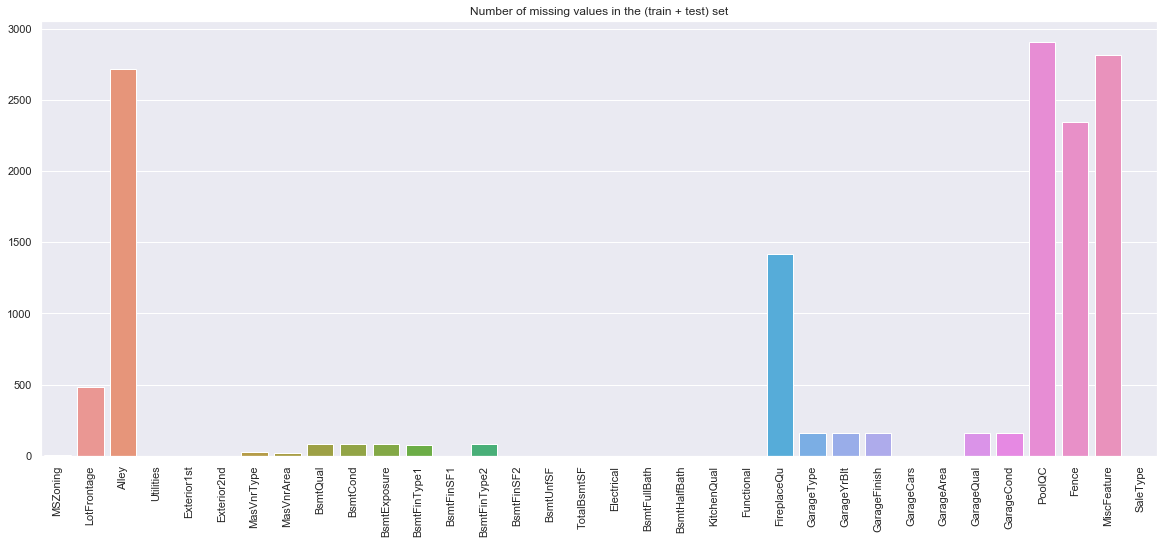

In [48]:
plt.figure(figsize=(20,8))
sns.barplot(x=missing_data_df(full_data).index,y = missing_data_df(full_data)) # How many missing values are there in the trainset?
plt.xticks(rotation='90')
plt.title('Number of missing values in the (train + test) set')

### Imputing missing values

- Numeric columns

In [49]:
num_cols = train.select_dtypes(include=[np.number]).columns
cat_cols = train.select_dtypes(exclude=[np.number]).columns

In [50]:
missing_data_df(full_data[num_cols])

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [51]:
# This cell imputes missing values for numeric columns
fill_with_zero = ['MasVnrArea','GarageYrBlt','GarageArea', 'GarageCars']
fill_with_mean = ['LotFrontage','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
fill_with_mode = ['BsmtFullBath','BsmtHalfBath']

full_data.loc[:,fill_with_zero] = full_data[fill_with_zero].fillna(0)
full_data.loc[:,fill_with_mean] = full_data[fill_with_mean].fillna(train[fill_with_mean].mean())
for col in fill_with_mode:
    full_data[col] = full_data[col].fillna(train[col].mode()[0])

- Categorical columns

In [52]:
missing_data_df(full_data[cat_cols])

MSZoning           4
Alley           2719
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2908
Fence           2346
MiscFeature     2812
SaleType           1
dtype: int64

In [53]:
# This cell imputes missing values for categorical columns

fill_with_mode_cat = ['MSZoning','MasVnrType','Electrical', 'KitchenQual','Functional', 'SaleType']
fill_with_none = ['Alley','Exterior1st', 'Exterior2nd','BsmtQual', 'BsmtCond', 
                  'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature' ]

full_data.loc[:,fill_with_none] = full_data[fill_with_none].fillna('None')
for col in fill_with_mode_cat:
    full_data[col] = full_data[col].fillna(train[col].mode()[0])

In [54]:
full_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

As you can see from the value counts above, all but one house does not have water connection (NoSeWa). Therefore, it makes no sense to keep the `Utilities` predictor.

In [55]:
full_data = full_data.drop('Utilities', axis=1)

In [56]:
print('Number of missing values present = %i' %np.sum(full_data.isnull().sum(axis=0)))

Number of missing values present = 0


### Feature engineering

- Add the total area of a house (including Garage) as a new predictor variable in out dataset

In [57]:
## Add the total area of a house (including Garage) as a new predictor variable in out dataset
full_data['total_area'] = full_data[['GrLivArea','TotalBsmtSF','GarageArea']].sum(axis=1)

- Since `GrLivArea` is the feature which seems to predict the `SalePrice` best, let's create a feature which is square of the living area.

In [58]:
full_data['GrLivArea_sq'] = full_data['GrLivArea']**2

- Total number of bathrooms might be a good choice? The half-bathrooms are weighted accordingly.

In [59]:
full_data['Total_bath'] = full_data['FullBath']+0.5*full_data['HalfBath']+full_data['BsmtFullBath']+0.5*full_data['BsmtHalfBath']

- Total porch area

In [60]:
full_data['Total_porchSF'] = full_data['WoodDeckSF']+full_data['OpenPorchSF']+full_data['EnclosedPorch']+full_data['3SsnPorch']+full_data['ScreenPorch']

In [61]:
np.corrcoef(full_data.loc[:len(target)-1,'Total_porchSF'], target)
#np.corrcoef(full_data.loc[0:len(target),'GrLivArea_sq'], target)

array([[1.        , 0.39289688],
       [0.39289688, 1.        ]])

Looks good! The correlation coefficient improved

In [62]:
num_cols = full_data.select_dtypes(include=[np.number]).columns
cat_cols = full_data.select_dtypes(exclude=[np.number]).columns

### Analying `SalePrice`: the target variable

[Text(0.5, 0, 'Normalized Sale price (z-scores)')]

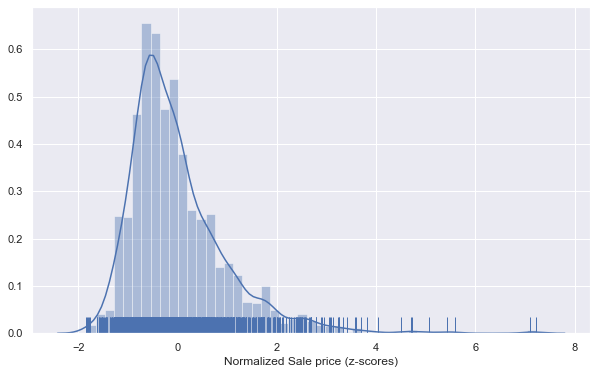

In [63]:
plt.figure(figsize=(10,6))
z = (target- np.mean(target))/np.std(target)
ax = sns.distplot(z,rug=True)
ax.set(xlabel = 'Normalized Sale price (z-scores)')

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74213.25959976624, 180932.91906721535, 0.9320154492892367))

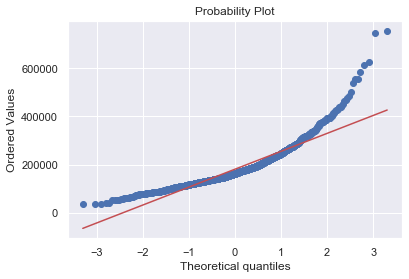

In [64]:
from scipy import stats
stats.probplot(target, plot=plt)

In [65]:
target = np.log(target)
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html

In [66]:
target.describe()

count    1458.000000
mean       12.024009
std         0.399715
min        10.460242
25%        11.774713
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'after transformation of SalePrice')

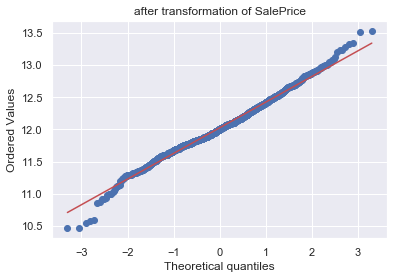

In [67]:
stats.probplot(target, plot=plt)
plt.title('after transformation of SalePrice')

### Analyzing skewed variables

- Let's look at the QQ plots of the highest correlated variables

((array([-3.48712442, -3.24243636, -3.10707149, ...,  3.10707149,
          3.24243636,  3.48712442]),
  array([ 105.,  160.,  173., ..., 3200., 3206., 5095.])),
 (386.6273694083876, 1078.1583434438314, 0.9716586471496782))

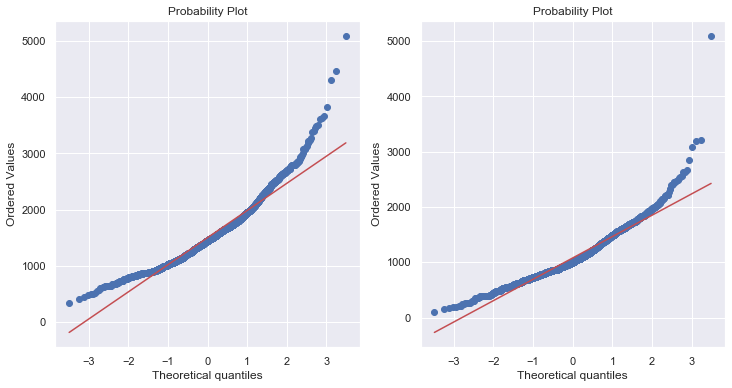

In [68]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
stats.probplot(full_data.loc[full_data['GrLivArea']>0, 'GrLivArea'], plot=ax[0])
stats.probplot(full_data.loc[full_data['TotalBsmtSF']>0, 'TotalBsmtSF'], plot=ax[1])

- After log transformation

Text(0.5, 1.0, 'TotalBsmtSF after Log transform')

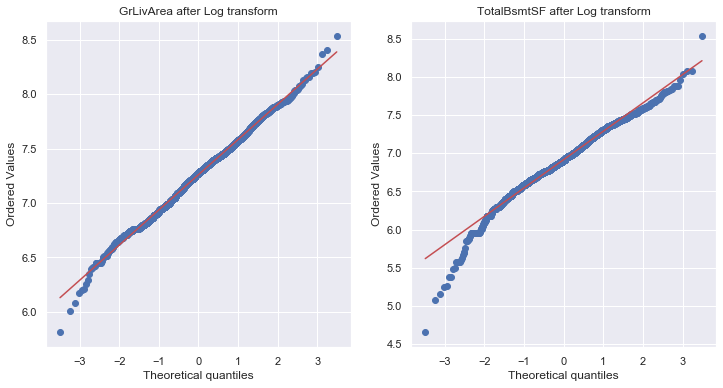

In [69]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
stats.probplot(np.log(full_data.loc[full_data['GrLivArea']>0, 'GrLivArea']), plot=ax[0])
stats.probplot(np.log(full_data.loc[full_data['TotalBsmtSF']>0, 'TotalBsmtSF']), plot=ax[1])
ax[0].set_title('GrLivArea after Log transform')
ax[1].set_title('TotalBsmtSF after Log transform')

In [70]:
skew_list = []
for num_col in num_cols:
    skew_list.append([num_col, full_data[num_col].skew()])
skew_df = pd.DataFrame(skew_list, columns=['Feature', 'Skewness']).sort_values(by='Skewness', ascending=False).reset_index()
skew_df.head(10)

,index,Feature,Skewness
0,33,MiscVal,21.950962
1,32,PoolArea,17.697766
2,2,LotArea,13.116240
3,14,LowQualFinSF,12.090757
4,30,3SsnPorch,11.377932
5,21,KitchenAbvGr,4.302763
6,9,BsmtFinSF2,4.146544
7,29,EnclosedPorch,4.004404
8,31,ScreenPorch,3.947131
9,17,BsmtHalfBath,3.932018


((array([-1.93807102, -1.52350933, -1.27167259, -1.08178602, -0.92453898,
         -0.78737238, -0.66363796, -0.54932825, -0.44179391, -0.33915032,
         -0.23996855, -0.143098  , -0.04755496,  0.04755496,  0.143098  ,
          0.23996855,  0.33915032,  0.44179391,  0.54932825,  0.66363796,
          0.78737238,  0.92453898,  1.08178602,  1.27167259,  1.52350933,
          1.93807102]),
  array([ 53,  80,  80,  80, 120, 144, 156, 205, 232, 234, 360, 360, 371,
         384, 390, 392, 397, 420, 473, 479, 481, 513, 514, 515, 528, 572])),
 (167.89753125051496, 328.1923076923077, 0.9620762193707233))

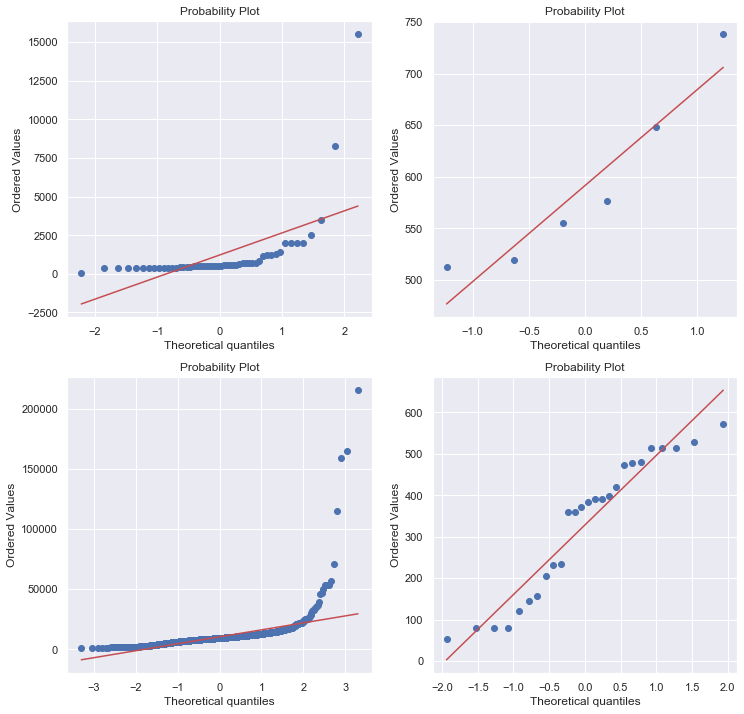

In [71]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
stats.probplot(train.loc[train['MiscVal']>0, 'MiscVal'], plot=ax[0][0])
stats.probplot(train.loc[train['PoolArea']>0, 'PoolArea'], plot=ax[0][1])
stats.probplot(train.loc[train['LotArea']>0, 'LotArea'], plot=ax[1][0])
stats.probplot(train.loc[train['LowQualFinSF']>0, 'LowQualFinSF'], plot=ax[1][1])

In [72]:
skew_gtr1_list = list(skew_df.loc[np.abs(skew_df['Skewness'])>0.8,'Feature'])

In [73]:
full_data.loc[:, skew_gtr1_list] = full_data.loc[:, skew_gtr1_list].apply(np.log1p)

In [74]:
#full_data.loc[:, 'GrLivArea'] = full_data.loc[:,'GrLivArea'].apply(lambda x: np.log(x))
#full_data.loc[:, 'TotalBsmtSF'] = full_data.loc[:, 'TotalBsmtSF'].apply(lambda x: np.log1p(x))
#full_data.loc[:, 'GarageArea'] = full_data.loc[:, 'GarageArea'].apply(lambda x: np.log1p(x))
#full_data.loc[:, 'LotArea'] = full_data.loc[:, 'LotArea'].apply(lambda x: np.log(x))
#full_data.loc[:, 'GrLivArea_sq'] = full_data.loc[:,'GrLivArea'].apply(lambda x: np.log(x))

## Encoding categorical features

In [75]:
ordinal_cat_cols = ['Alley', 'Street',  'LandSlope', 'LotShape',
                    'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond', 'BsmtExposure',
                    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir',
                     'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                    'GarageQual','GarageCond','PavedDrive', 'PoolQC', 'Fence', 'GarageType', 'HouseStyle', 'Electrical']

#ordinal_cat_cols = [  'HouseStyle', 'Electrical', , ,'GarageType'


nominal_cat_cols = [ 'MSZoning', 'LandContour', 'LotConfig', 
                    'Neighborhood', 'Condition1', 'Condition2', 
                    'BldgType', 'RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                    'Foundation', 'Heating', 'MiscFeature', 'SaleType', 'SaleCondition']

In [76]:
len(ordinal_cat_cols) + len(nominal_cat_cols) == len(cat_cols)

True

### Label Encoding ordinal categorical variables

In [77]:
enc =LabelEncoder()
full_data[ordinal_cat_cols] = full_data[ordinal_cat_cols].apply(enc.fit_transform)
#for ordinal_cat_col in ordinal_cat_cols:
#    enc = LabelEncoder()
#    train_copy.loc[:,ordinal_cat_col] = enc.fit_transform(train[ordinal_cat_col])
#    test_copy.loc[:,ordinal_cat_col] = enc.transform(test[ordinal_cat_col])

### Feature scaling numeric features

In [78]:
num_cols = full_data.select_dtypes(include=[np.number]).columns

In [79]:
train = full_data.iloc[:len(train)]  
test  = full_data.iloc[len(train):]

In [80]:
scaler = StandardScaler()
train_copy = train.copy()
test_copy = test.copy()
train_copy.loc[:,num_cols] = scaler.fit_transform(train[num_cols])
test_copy.loc[:,num_cols] = scaler.transform(test[num_cols])
train = train_copy
test = test_copy
full_data = pd.concat([train,test], axis=0,ignore_index=True)

### One-Hot Encoding nominal categorical variables

In [81]:
full_data = pd.get_dummies(full_data,drop_first=False)
print('The shape of the data matrix after pre-processing: {}' .format(full_data.shape))

The shape of the data matrix after pre-processing: (2917, 208)


In [82]:
#Removing highly correlated predictors
#full_data = full_data.drop(['GarageArea', '1stFlrSF', 'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'], axis=1)

In [83]:
train= full_data.iloc[:len(train)]
test = full_data.iloc[len(train):]

In [84]:
print(train.shape) # 'Id' column dropped
print(test.shape)

(1458, 208)
(1459, 208)


## Regression models

In [85]:
from sklearn.model_selection import train_test_split, KFold

In [86]:
# Split the dataset into training and dev set
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=123)

## Linear models

In [87]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error as mse

### Lasso

In [88]:
alpha_list_lasso = [5e-5,8e-5,1e-4, 5e-4,1e-3, 1e-2,0.1]
training_score = []
test_score = []
feature_selection = []
for alpha in alpha_list_lasso:
    lasso = Lasso(alpha = alpha,max_iter=2e4)
    lasso.fit(X_train, y_train)
    training_score.append(lasso.score(X_train, y_train))  # This score is R_squared
    test_score.append(lasso.score(X_test,y_test))
    feature_selection.append(np.sum(lasso.coef_!=0))

Text(0, 0.5, '# of features selected')

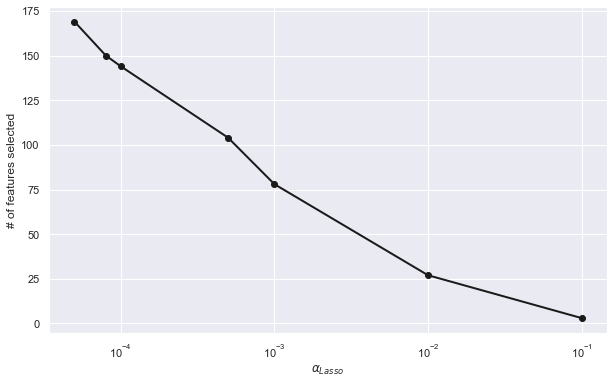

In [89]:
plt.figure(figsize=(10,6))
plt.semilogx(alpha_list_lasso, feature_selection, 'ko-',lw=2)
plt.xlabel(r'$\alpha_{Lasso}$')
plt.ylabel('# of features selected')

In [90]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)

In [97]:
val_sc_mean = []
for alpha in alpha_list_lasso:
    model = Lasso(alpha = alpha, random_state=10,max_iter=1e5)
    val_sc = cross_val_score(model,X_train,y_train,cv=kf,scoring='neg_mean_squared_error')
    val_sc_mean.append(np.mean(np.sqrt(np.abs(val_sc))))
    
index = val_sc_mean.index(np.min(val_sc_mean))
print('\nThe best mean CV score (rmse)=  %.7f which corresponds to alpha = %.4f' 
      %(np.min(val_sc_mean), alpha_list_lasso[index])) 
pd.DataFrame(zip(alpha_list_lasso,val_sc_mean),columns=['alpha','Mean CV score (RMSE)'])


The best mean CV score (rmse)=  0.1130450 which corresponds to alpha = 0.0005


,alpha,Mean CV score (RMSE)
0,0.00005,0.120964
1,0.00008,0.118867
2,0.00010,0.117687
3,0.00050,0.113045
4,0.00100,0.115087
5,0.01000,0.124940
6,0.10000,0.197930


Text(0.5, 1.0, 'Lasso regression')

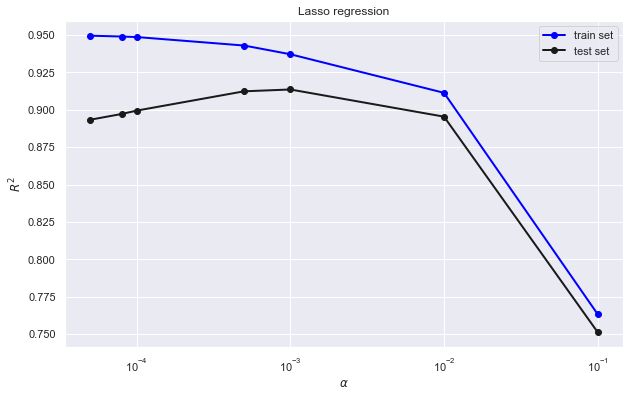

In [98]:
plt.figure(figsize=(10,6))
plt.semilogx(alpha_list_lasso,training_score, marker='o',color='blue', lw=2, label='train set')
plt.semilogx(alpha_list_lasso,test_score, 'ko-', lw=2, label='test set')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^{2}$')
plt.legend()
plt.title('Lasso regression')

In [99]:
lasso_final = Lasso(alpha = 0.0001, random_state=10,max_iter=5000)
lasso_final.fit(X_train,y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=5000,
      normalize=False, positive=False, precompute=False, random_state=10,
      selection='cyclic', tol=0.0001, warm_start=False)

In [94]:
coef = pd.Series(lasso_final.coef_, index = X_train.columns)

In [95]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

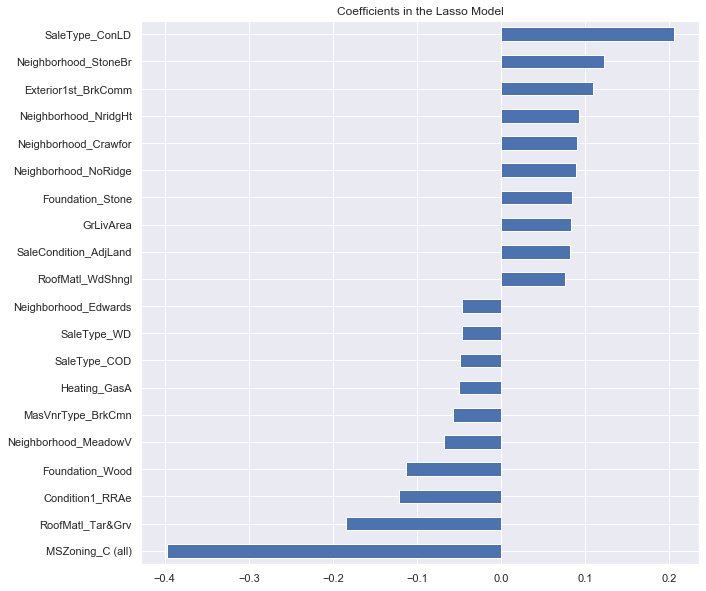

In [96]:
plt.figure(figsize=(10,10))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Ridge regression

In [100]:
alpha_list_ridge = [0.1,0.6, 1,1.5, 2, 3,  5, 7, 8, 10]
validation_score_mean = []
for alpha in alpha_list_ridge:
    validation_score = cross_val_score(Ridge(alpha = alpha, solver='svd',
                                             random_state=123,max_iter=5000),X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    validation_score_mean.append(np.mean(np.sqrt(np.abs(validation_score))))
#    print('alpha = ', alpha, 'mean CV score = ', validation_score_mean[-1])

index = np.where(validation_score_mean == np.min(validation_score_mean))[0][0]
print('\nThe best mean CV score (rmse)=  %.7f which corresponds to alpha = %.1f' 
      %(np.min(validation_score_mean), alpha_list_ridge[index])) 

pd.DataFrame(zip(alpha_list_ridge,validation_score_mean),columns=['alpha','Mean CV score (RMSE)'])    


The best mean CV score (rmse)=  0.1143672 which corresponds to alpha = 5.0


,alpha,Mean CV score (RMSE)
0,0.1,0.120965
1,0.6,0.117130
2,1.0,0.116021
3,1.5,0.115309
4,2.0,0.114922
5,3.0,0.114555
6,5.0,0.114367
7,7.0,0.114382
8,8.0,0.114414
9,10.0,0.114497


Text(0.5, 1.0, 'Ridge regression')

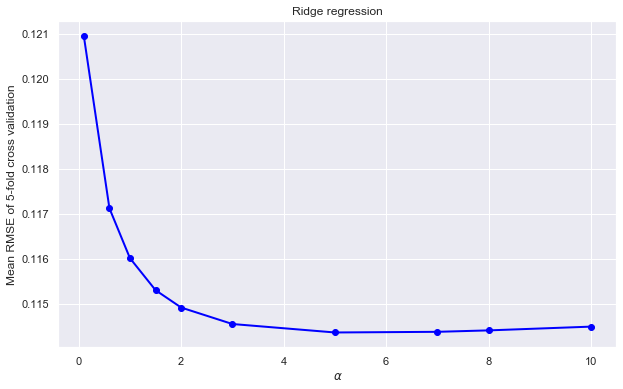

In [101]:
plt.figure(figsize=(10,6))
plt.plot(alpha_list_ridge,validation_score_mean, marker='o',color='blue', lw=2)
plt.xlabel('$\\alpha$')
plt.ylabel('Mean RMSE of 5-fold cross validation')
plt.title('Ridge regression')

Text(0.5, 1.0, 'Ridge regression')

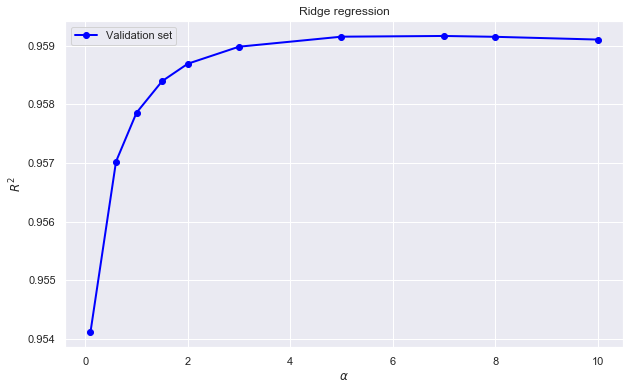

In [102]:
validation_score_r2_mean = []
for alpha in alpha_list_ridge:
    validation_score_r2 = cross_val_score(Ridge(alpha = alpha, solver='svd',
                                             random_state=123,max_iter=5000),X_train,y_train,cv=5,scoring='r2')
    validation_score_r2_mean.append(np.mean(np.sqrt(np.abs(validation_score_r2))))

plt.figure(figsize=(10,6))
plt.plot(alpha_list_ridge,validation_score_r2_mean, marker='o',color='blue', lw=2, label='Validation set')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^{2}$')
plt.legend()
plt.title('Ridge regression')


In [103]:
## test exercise to verify the realtion between R^2 and mse.

#ridge_ex = Ridge(alpha = 1)
#ridge_ex.fit(X_train, y_train)
#TSS = np.sum(((y_train - y_train.mean())**2).values)
#SSE = np.sum((ridge_ex.predict(X_train) - y_train)**2)
#R_squared = ridge_ex.score(X_train, y_train)
#R_squared -1 +SSE/TSS

In [105]:
ridge_final = Ridge(alpha = 5, random_state=123,max_iter=5000)
ridge_final.fit(X_train,y_train)
#rmsle(ridge_final.predict(X_test), y_test)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=5000, normalize=False,
      random_state=123, solver='auto', tol=0.001)

### Elastic net

In [106]:
#If a is L1 coefficient and b is L2 coefficient, then alpha = a + b and l1_ratio = a / (a + b)

alpha_list_enet = [ 5e-4, 0.001, 0.005, 0.01, 0.05, 0.1,0.5,1]

validation_score_mean = []
for alpha in alpha_list_enet:
    validation_score = cross_val_score(ElasticNet(alpha = alpha, l1_ratio = 0.3,
                                             random_state=123,max_iter=50000),X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    validation_score_mean.append(np.mean(np.sqrt(np.abs(validation_score))))

index = np.where(validation_score_mean == np.min(validation_score_mean))[0][0]
print('\nThe best mean CV score (rmse)=  %.7f which corresponds to alpha = %.4f' 
      %(np.min(validation_score_mean), alpha_list_enet[index])) 
pd.DataFrame(zip(alpha_list_enet,validation_score_mean),columns=['alpha','Mean CV score (RMSE)'])        


The best mean CV score (rmse)=  0.1130266 which corresponds to alpha = 0.0010


,alpha,Mean CV score (RMSE)
0,0.0005,0.113966
1,0.0010,0.113027
2,0.0050,0.117613
3,0.0100,0.120117
4,0.0500,0.128424
5,0.1000,0.144109
6,0.5000,0.253380
7,1.0000,0.375086


Text(0.5, 1.0, 'Elastic net regression')

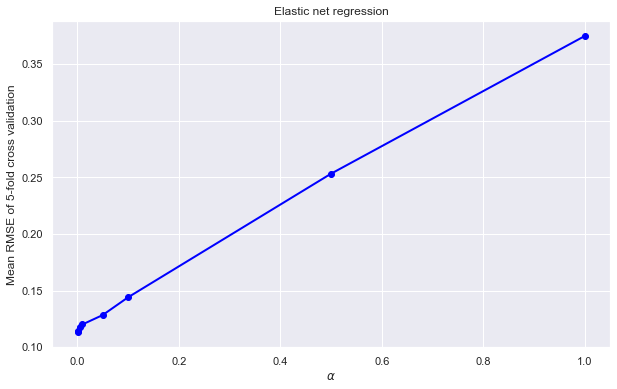

In [107]:
plt.figure(figsize=(10,6))
plt.plot(alpha_list_enet,validation_score_mean, marker='o',color='blue', lw=2)
plt.xlabel('$\\alpha$')
plt.ylabel('Mean RMSE of 5-fold cross validation')
plt.title('Elastic net regression')

In [112]:
def grid_search(clf, parameters, X, y, n_jobs= -1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =2)
    else:
        print('Doing grid search')
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose =2)
    gs.fit(X, y)
    print("mean test score (weighted by split size) of CV rounds [RMSE]: ",np.sqrt(abs(gs.cv_results_['mean_test_score'])))
    print ("\nBest parameter set", gs.best_params_, "Corresponding mean CV score (rmse)",np.sqrt(abs(gs.best_score_)))
    best = gs.best_estimator_
    return best

In [113]:
enet_gs = ElasticNet(random_state=13,max_iter=50000)
param = {
'alpha' : [1e-4,5e-4, 0.001, 0.005, 0.01, 0.05, 0.1],
'l1_ratio': [0.1,0.3,0.5,0.7]
}
enet_gs  = grid_search(enet_gs, param,X_train,y_train, n_folds=5, score_func= 'neg_mean_squared_error')

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   25.2s finished


mean test score (weighted by split size) of CV rounds [RMSE]:  [0.12074761 0.11935369 0.11832516 0.11749031 0.11639752 0.11423344
 0.11352257 0.11354287 0.1143463  0.11325913 0.11362984 0.11418993
 0.11429392 0.1180613  0.11994207 0.12128387 0.11651447 0.12071588
 0.12276849 0.12369244 0.12317852 0.12920523 0.13985442 0.15148311
 0.12616096 0.14505528 0.1632535  0.17975951]

Best parameter set {'alpha': 0.001, 'l1_ratio': 0.3} Corresponding mean CV score (rmse) 0.11325912649733705


In [114]:
enet_final = ElasticNet(alpha=.001,l1_ratio=0.1, max_iter=50000)
enet_final.fit(X_train, y_train)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=50000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

### XGBoost

In [115]:
from xgboost.sklearn import XGBRegressor

In [116]:
def rmsle(log_pred, log_actual):
    log_pred = np.array([np.log(val + 1) for val in log_pred])
    log_actual = np.array([np.log(val + 1) for val in log_actual])
    logsqerror = (log_pred - log_actual) ** 2
    return np.sqrt(np.mean(logsqerror))

In [117]:
param = {}
param['learning_rate'] = 0.05
param['verbosity'] = 1
param['colsample_bylevel'] = 0.7
param['colsample_bytree'] = 0.8
param['subsample'] = 0.6
param['reg_lambda']= 1.5
param['max_depth'] = 3
param['n_estimators'] = 800
param['seed']= 10
param['min_child_weight'] = 4
#param['gamma'] = 0.05
xgb= XGBRegressor(**param)
xgb.fit(X_train, y_train, eval_metric=['rmse'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=40)

[0]	validation_0-rmse:10.9563	validation_1-rmse:10.9588
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 40 rounds.
[1]	validation_0-rmse:10.4109	validation_1-rmse:10.4133
[2]	validation_0-rmse:9.89265	validation_1-rmse:9.89501
[3]	validation_0-rmse:9.40093	validation_1-rmse:9.40323
[4]	validation_0-rmse:8.93331	validation_1-rmse:8.93556
[5]	validation_0-rmse:8.48903	validation_1-rmse:8.49123
[6]	validation_0-rmse:8.06623	validation_1-rmse:8.06837
[7]	validation_0-rmse:7.66446	validation_1-rmse:7.66655
[8]	validation_0-rmse:7.28306	validation_1-rmse:7.28507
[9]	validation_0-rmse:6.92117	validation_1-rmse:6.92312
[10]	validation_0-rmse:6.57764	validation_1-rmse:6.57951
[11]	validation_0-rmse:6.25215	validation_1-rmse:6.25395
[12]	validation_0-rmse:5.94164	validation_1-rmse:5.94336
[13]	validation_0-rmse:5.64755	validation_1-rmse:5.64919
[14]	validation_0-rmse:5.36729	validation_1-rmse:5.36

[138]	validation_0-rmse:0.099689	validation_1-rmse:0.1239
[139]	validation_0-rmse:0.099389	validation_1-rmse:0.123734
[140]	validation_0-rmse:0.099107	validation_1-rmse:0.123579
[141]	validation_0-rmse:0.09882	validation_1-rmse:0.123427
[142]	validation_0-rmse:0.098504	validation_1-rmse:0.12328
[143]	validation_0-rmse:0.098119	validation_1-rmse:0.122989
[144]	validation_0-rmse:0.097779	validation_1-rmse:0.122766
[145]	validation_0-rmse:0.097465	validation_1-rmse:0.122574
[146]	validation_0-rmse:0.097132	validation_1-rmse:0.122334
[147]	validation_0-rmse:0.096872	validation_1-rmse:0.122237
[148]	validation_0-rmse:0.096693	validation_1-rmse:0.122136
[149]	validation_0-rmse:0.096442	validation_1-rmse:0.122074
[150]	validation_0-rmse:0.09619	validation_1-rmse:0.12202
[151]	validation_0-rmse:0.095973	validation_1-rmse:0.121849
[152]	validation_0-rmse:0.095662	validation_1-rmse:0.121602
[153]	validation_0-rmse:0.095399	validation_1-rmse:0.121371
[154]	validation_0-rmse:0.095209	validation_1-

[275]	validation_0-rmse:0.078369	validation_1-rmse:0.116305
[276]	validation_0-rmse:0.078283	validation_1-rmse:0.116451
[277]	validation_0-rmse:0.078127	validation_1-rmse:0.116407
[278]	validation_0-rmse:0.077983	validation_1-rmse:0.116447
[279]	validation_0-rmse:0.077855	validation_1-rmse:0.116457
[280]	validation_0-rmse:0.077788	validation_1-rmse:0.116443
[281]	validation_0-rmse:0.077656	validation_1-rmse:0.116356
[282]	validation_0-rmse:0.077609	validation_1-rmse:0.116326
[283]	validation_0-rmse:0.077516	validation_1-rmse:0.11641
[284]	validation_0-rmse:0.077407	validation_1-rmse:0.116436
[285]	validation_0-rmse:0.077234	validation_1-rmse:0.11635
[286]	validation_0-rmse:0.077154	validation_1-rmse:0.116367
[287]	validation_0-rmse:0.076971	validation_1-rmse:0.116307
[288]	validation_0-rmse:0.076846	validation_1-rmse:0.116213
[289]	validation_0-rmse:0.076798	validation_1-rmse:0.116229
[290]	validation_0-rmse:0.076645	validation_1-rmse:0.116244
[291]	validation_0-rmse:0.076563	validatio

[413]	validation_0-rmse:0.065724	validation_1-rmse:0.115103
[414]	validation_0-rmse:0.065685	validation_1-rmse:0.115039
[415]	validation_0-rmse:0.065611	validation_1-rmse:0.115042
[416]	validation_0-rmse:0.065553	validation_1-rmse:0.115033
[417]	validation_0-rmse:0.065502	validation_1-rmse:0.115066
[418]	validation_0-rmse:0.06543	validation_1-rmse:0.115071
[419]	validation_0-rmse:0.065403	validation_1-rmse:0.115067
[420]	validation_0-rmse:0.065341	validation_1-rmse:0.115073
[421]	validation_0-rmse:0.065256	validation_1-rmse:0.115058
[422]	validation_0-rmse:0.065209	validation_1-rmse:0.114968
[423]	validation_0-rmse:0.065102	validation_1-rmse:0.115004
[424]	validation_0-rmse:0.064928	validation_1-rmse:0.114951
[425]	validation_0-rmse:0.064896	validation_1-rmse:0.114966
[426]	validation_0-rmse:0.064845	validation_1-rmse:0.114943
[427]	validation_0-rmse:0.06482	validation_1-rmse:0.114934
[428]	validation_0-rmse:0.064757	validation_1-rmse:0.114895
[429]	validation_0-rmse:0.064725	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bytree=0.8, gamma=0, learning_rate=0.05,
             max_delta_step=0, max_depth=3, min_child_weight=4, missing=None,
             n_estimators=800, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1,
             seed=10, silent=True, subsample=0.6, verbosity=1)

In [ ]:
xgb_imp_df = pd.DataFrame({'feature_imp':xgb.feature_importances_, 'Feature_name': X_train.columns}).sort_values(by='feature_imp', ascending=False).iloc[:20]
plt.figure(figsize=(15,6))
plt.barh(xgb_imp_df['Feature_name'][::-1],xgb_imp_df['feature_imp'][::-1],align='center')
plt.xlabel('Relative importance in XGBoost')
plt.ylabel('Features')
plt.title('Top 20 important features determied by XGBoost')
plt.show()

In [119]:
xgbgrid_search = XGBRegressor()
param = {
'learning_rate': [0.05],#[0.1,0.2],
#'verbosity': [1],
'colsample_bylevel': [0.7,0.8],
'colsample_bytree': [0.7,0.8],
'subsample' : [0.6,0.7], #0.8
'n_estimators': [500],
'reg_lambda': [2.5], #1.5,2,
'max_depth': [2,3],#4
 'min_child_weight': [1,2,4],   
 'seed': [10]   
}
xgbCV  = grid_search(xgbgrid_search, param,X_train,y_train, n_folds=4, score_func= 'neg_mean_squared_error')

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  1.7min finished


mean test score (weighted by split size) of CV rounds [RMSE]:  [0.12134013 0.11993951 0.12132674 0.12145027 0.12255831 0.1221332
 0.12094921 0.12225409 0.1236294  0.11999281 0.12258102 0.12236484
 0.12132159 0.12156533 0.12054432 0.12192657 0.12191875 0.12262541
 0.12274836 0.12240517 0.11994182 0.12062543 0.1224508  0.12091363
 0.1205817  0.11895319 0.12163971 0.12072931 0.12261638 0.12170635
 0.1215913  0.12212754 0.12160781 0.12269772 0.12178536 0.12244273
 0.12072261 0.12207226 0.12113704 0.12130593 0.12347205 0.12248948
 0.12307293 0.12238817 0.1208771  0.12115989 0.12165228 0.12162142]

Best parameter set {'colsample_bylevel': 0.8, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 500, 'reg_lambda': 2.5, 'seed': 10, 'subsample': 0.7} Corresponding mean CV score (rmse) 0.11895318763443255


In [120]:
xgbCV.fit(X_train, y_train, eval_metric=['rmse'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=40)

[0]	validation_0-rmse:10.9572	validation_1-rmse:10.9596
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 40 rounds.
[1]	validation_0-rmse:10.4114	validation_1-rmse:10.4138
[2]	validation_0-rmse:9.89326	validation_1-rmse:9.89562
[3]	validation_0-rmse:9.40113	validation_1-rmse:9.40343
[4]	validation_0-rmse:8.93331	validation_1-rmse:8.93557
[5]	validation_0-rmse:8.48875	validation_1-rmse:8.49095
[6]	validation_0-rmse:8.06675	validation_1-rmse:8.06889
[7]	validation_0-rmse:7.66568	validation_1-rmse:7.66775
[8]	validation_0-rmse:7.28476	validation_1-rmse:7.28677
[9]	validation_0-rmse:6.92215	validation_1-rmse:6.92409
[10]	validation_0-rmse:6.57824	validation_1-rmse:6.58011
[11]	validation_0-rmse:6.25288	validation_1-rmse:6.25468
[12]	validation_0-rmse:5.94184	validation_1-rmse:5.94357
[13]	validation_0-rmse:5.64642	validation_1-rmse:5.64806
[14]	validation_0-rmse:5.36604	validation_1-rmse:5.36

[138]	validation_0-rmse:0.115189	validation_1-rmse:0.131888
[139]	validation_0-rmse:0.114811	validation_1-rmse:0.131572
[140]	validation_0-rmse:0.114462	validation_1-rmse:0.131321
[141]	validation_0-rmse:0.114146	validation_1-rmse:0.131109
[142]	validation_0-rmse:0.113827	validation_1-rmse:0.130783
[143]	validation_0-rmse:0.113604	validation_1-rmse:0.130732
[144]	validation_0-rmse:0.113288	validation_1-rmse:0.13049
[145]	validation_0-rmse:0.113002	validation_1-rmse:0.130237
[146]	validation_0-rmse:0.112791	validation_1-rmse:0.130098
[147]	validation_0-rmse:0.112443	validation_1-rmse:0.129809
[148]	validation_0-rmse:0.112114	validation_1-rmse:0.129573
[149]	validation_0-rmse:0.1118	validation_1-rmse:0.129359
[150]	validation_0-rmse:0.111559	validation_1-rmse:0.129267
[151]	validation_0-rmse:0.111306	validation_1-rmse:0.129148
[152]	validation_0-rmse:0.11097	validation_1-rmse:0.128871
[153]	validation_0-rmse:0.110626	validation_1-rmse:0.128564
[154]	validation_0-rmse:0.110296	validation_

[276]	validation_0-rmse:0.092982	validation_1-rmse:0.120488
[277]	validation_0-rmse:0.092894	validation_1-rmse:0.120427
[278]	validation_0-rmse:0.09282	validation_1-rmse:0.120414
[279]	validation_0-rmse:0.092722	validation_1-rmse:0.120401
[280]	validation_0-rmse:0.092642	validation_1-rmse:0.120402
[281]	validation_0-rmse:0.092596	validation_1-rmse:0.120379
[282]	validation_0-rmse:0.092527	validation_1-rmse:0.120418
[283]	validation_0-rmse:0.092422	validation_1-rmse:0.120375
[284]	validation_0-rmse:0.092343	validation_1-rmse:0.120305
[285]	validation_0-rmse:0.092229	validation_1-rmse:0.120233
[286]	validation_0-rmse:0.092145	validation_1-rmse:0.120286
[287]	validation_0-rmse:0.092082	validation_1-rmse:0.120294
[288]	validation_0-rmse:0.091996	validation_1-rmse:0.120353
[289]	validation_0-rmse:0.091915	validation_1-rmse:0.120293
[290]	validation_0-rmse:0.091846	validation_1-rmse:0.120225
[291]	validation_0-rmse:0.091757	validation_1-rmse:0.120205
[292]	validation_0-rmse:0.091695	validati

[413]	validation_0-rmse:0.083945	validation_1-rmse:0.118088
[414]	validation_0-rmse:0.083909	validation_1-rmse:0.118048
[415]	validation_0-rmse:0.083844	validation_1-rmse:0.118059
[416]	validation_0-rmse:0.083803	validation_1-rmse:0.118005
[417]	validation_0-rmse:0.083735	validation_1-rmse:0.117991
[418]	validation_0-rmse:0.083673	validation_1-rmse:0.118011
[419]	validation_0-rmse:0.083642	validation_1-rmse:0.117981
[420]	validation_0-rmse:0.083579	validation_1-rmse:0.117905
[421]	validation_0-rmse:0.083521	validation_1-rmse:0.117888
[422]	validation_0-rmse:0.083489	validation_1-rmse:0.117873
[423]	validation_0-rmse:0.083439	validation_1-rmse:0.117866
[424]	validation_0-rmse:0.083378	validation_1-rmse:0.117944
[425]	validation_0-rmse:0.083361	validation_1-rmse:0.117952
[426]	validation_0-rmse:0.083335	validation_1-rmse:0.117963
[427]	validation_0-rmse:0.083251	validation_1-rmse:0.117935
[428]	validation_0-rmse:0.083204	validation_1-rmse:0.117932
[429]	validation_0-rmse:0.08315	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
             colsample_bytree=0.7, gamma=0, learning_rate=0.05,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=2.5, scale_pos_weight=1,
             seed=10, silent=True, subsample=0.7)

### Random Forest regressor

In [122]:
rfmodel = RandomForestRegressor(n_estimators = 800, max_features = 70, max_depth=None, 
                                n_jobs= -1, min_samples_split= 3, min_samples_leaf = 1, 
                                random_state=123, verbose =0)


In [123]:
rfmodel.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=70, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [124]:
param ={
'n_estimators': [200,500],#300,700
 'max_features': [50,70,80], #30,40,100
#    'max_depth': [10,None], #5,8
    'min_samples_split': [3],#5
    'min_samples_leaf' : [1]#2
}
rfmodelgrid_search = RandomForestRegressor(n_jobs=-1, random_state=123)
rfmodelCV  = grid_search(rfmodelgrid_search, param,X_train,y_train, n_folds=4,score_func='neg_mean_squared_error')

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   20.5s finished


mean test score (weighted by split size) of CV rounds [RMSE]:  [0.13652816 0.13611554 0.136182   0.13583761 0.13645858 0.13618142]

Best parameter set {'max_features': 70, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500} Corresponding mean CV score (rmse) 0.13583760720161236


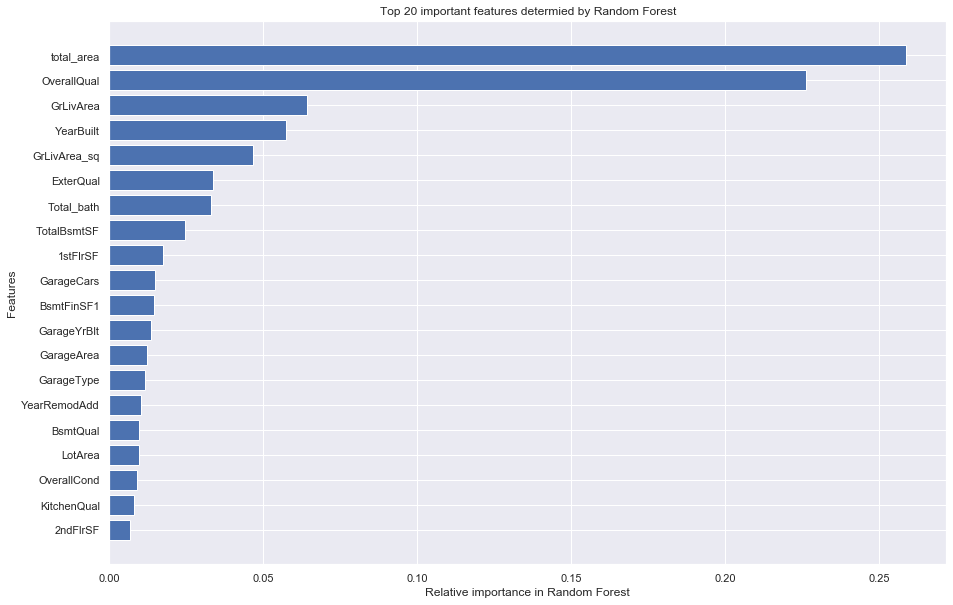

In [131]:
rf_imp_df = pd.DataFrame({'feature_imp':rfmodelCV.feature_importances_, 'Feature_name': X_train.columns}).sort_values(by='feature_imp', ascending=False).iloc[:20]
plt.figure(figsize=(15,10))
plt.barh(rf_imp_df['Feature_name'][::-1],rf_imp_df['feature_imp'][::-1],align='center')
plt.xlabel('Relative importance in Random Forest')
plt.ylabel('Features')
plt.title('Top 20 important features determied by Random Forest')
plt.show()

## Stacked models

In [126]:
from mlxtend.regressor import StackingCVRegressor, StackingRegressor
from mlxtend.plotting import plot_learning_curves

In [127]:
stack = StackingCVRegressor(regressors=(xgb,ridge_final, lasso_final),
                            meta_regressor=lasso_final, use_features_in_secondary=False,
                            random_state=10, n_jobs=-1)

print('5-fold cross validation scores:\n')

for clf, label in zip([xgb, ridge_final, lasso_final, stack], ['XGBoost', 'Ridge', 'Lasso', 
                                                'StackingCVRegressor (Lasso)']):
    scores = cross_val_score(clf, X_train.values, y_train.values, cv=5,scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(np.abs(scores))
    print("RMSE: %0.4f (+/- %0.4f) [%s]" % (rmse_scores.mean(), rmse_scores.std(), label))

5-fold cross validation scores:

RMSE: 0.1196 (+/- 0.0088) [XGBoost]
RMSE: 0.1144 (+/- 0.0089) [Ridge]
RMSE: 0.1162 (+/- 0.0086) [Lasso]
RMSE: 0.1122 (+/- 0.0091) [StackingCVRegressor (Lasso)]


In [128]:
stack.fit(X_train,y_train)

StackingCVRegressor(cv=5,
                    meta_regressor=Lasso(alpha=0.0001, copy_X=True,
                                         fit_intercept=True, max_iter=5000,
                                         normalize=False, positive=False,
                                         precompute=False, random_state=10,
                                         selection='cyclic', tol=0.0001,
                                         warm_start=False),
                    n_jobs=-1, pre_dispatch='2*n_jobs', random_state=10,
                    refit=True,
                    regressors=(XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_byleve...
                                Ridge(alpha=5, copy_X=True, fit_intercept=True,
                                      max_iter=5000, normalize=False,
                                      random_state=123, solver='auto',
                                      tol=0.001),
                           

## Final predictions

In [129]:
print(rmsle(np.exp(xgb.predict(X_test)), np.exp(y_test)))
print(rmsle(np.exp(rfmodelCV.predict(X_test)), np.exp(y_test)))
print(rmsle(np.exp(lasso_final.predict(X_test.values)), np.exp(y_test)))
print(rmsle(np.exp(ridge_final.predict(X_test.values)), np.exp(y_test)))
print(rmsle(np.exp(enet_final.predict(X_test.values)), np.exp(y_test)))
print(rmsle(np.exp(stack.predict(X_test.values)), np.exp(y_test)))

0.11481108804817591
0.12905220567725306
0.12139387422300488
0.1165673156937825
0.11784921629935663
0.11192704793827192


In [133]:
xgb_pred = np.exp(xgb.predict(test))
rf_pred = np.exp(rfmodelCV.predict(test))
lasso_pred = np.exp(lasso_final.predict(test))
ridge_pred = np.exp(ridge_final.predict(test))
enet_pred = np.exp(enet_final.predict(test))
stack_pred = np.exp(stack.predict(test.values))

In [134]:
#final_pred = np.mean([xgb_pred, stack_pred, lasso_pred, ridge_pred],axis=0,dtype=np.float64)
ensemble1_pred = (0.6*stack_pred + 0.4*lasso_pred)
ensemble2_pred =(0.2*stack_pred + 0.8*lasso_pred)
ensemble3_pred =(0.3*stack_pred + 0.3*lasso_pred + 0.4*xgb_pred)
ensemble4_pred =(0.5*stack_pred + 0.5*lasso_pred)
final_pred = ensemble4_pred

In [136]:
submission = pd.concat([test_id,pd.Series(final_pred, name='SalePrice')],axis=1)
submission.to_csv("final_pred.csv", index = False)